In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [3]:
# Read Aggregated  data
df = pd.read_csv('New_features.csv')

In [4]:
df.shape

(5410, 13)

In [5]:
df.columns

Index(['Provider', 'IP_average_claim_duration', 'OP_average_claim_duration', 'PotentialFraud', 'IP_Claims_Total', 'OP_Claims_Total', 'IP_Averagedaysinhospital', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt', 'IP_total_diagnosis', 'OP_total_diagnosis', 'IP_total_procedures', 'OP_total_procedures'], dtype='object')

In [6]:
df.head()

,Provider,IP_average_claim_duration,OP_average_claim_duration,PotentialFraud,IP_Claims_Total,OP_Claims_Total,IP_Averagedaysinhospital,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,IP_total_diagnosis,OP_total_diagnosis,IP_total_procedures,OP_total_procedures
0,PRV51001,5.0,1.0,No,97000.0,7640.0,5.0,890.0,475.0,36.0,44.0,3.0,0.0
1,PRV51003,5.0,2.0,Yes,573000.0,32670.0,5.0,823.0,665.0,503.0,190.0,48.0,0.0
2,PRV51004,0.0,1.0,No,0.0,52170.0,0.0,454.0,601.0,0.0,385.0,0.0,0.0
3,PRV51005,0.0,1.0,Yes,0.0,280910.0,0.0,399.0,476.0,0.0,3016.0,0.0,0.0
4,PRV51007,5.0,1.0,No,19000.0,14710.0,5.0,424.0,431.0,22.0,193.0,1.0,0.0


In [7]:
X=df.drop(columns=['Provider','PotentialFraud'])

In [8]:
X.shape

(5410, 11)

In [9]:
y=df['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

In [10]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [42]:
# comparison with and without tuning

In [43]:
# Logisttic regression
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression without tuning
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Store results
results = pd.DataFrame({
    'Model': ['Logistic Regression (No Tuning)'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-score': [f1],
    'ROC-AUC': [roc_auc]
})

print("Performance without tuning:\n", results)

Performance without tuning:
                              Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression (No Tuning)  0.944547   0.797101  0.544554  0.647059  0.957621


In [44]:
# Define hyperparameter grid
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'class_weight': ['balanced', None],
        'penalty': ['l1', 'l2']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs'],
        'class_weight': ['balanced', None],
        'penalty': ['l2']
    }
]

# Initialize model
log_reg_tuned = LogisticRegression(max_iter=1000, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(log_reg_tuned, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_tuned = best_log_reg.predict(X_test)
y_prob_tuned = best_log_reg.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

# Store tuned results
tuned_results = pd.DataFrame({
    'Model': ['Logistic Regression (Tuned)'],
    'Accuracy': [accuracy_tuned],
    'Precision': [precision_tuned],
    'Recall': [recall_tuned],
    'F1-score': [f1_tuned],
    'ROC-AUC': [roc_auc_tuned]
})

print("\nBest Hyperparameters:", grid_search.best_params_)
print("\nPerformance with tuning:\n", tuned_results)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Hyperparameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

Performance with tuning:
                          Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression (Tuned)  0.939002   0.830189  0.435644  0.571429  0.959114



Performance Comparison:
                              Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression (No Tuning)  0.944547   0.797101  0.544554  0.647059  0.957621
1      Logistic Regression (Tuned)  0.939002   0.830189  0.435644  0.571429  0.959114


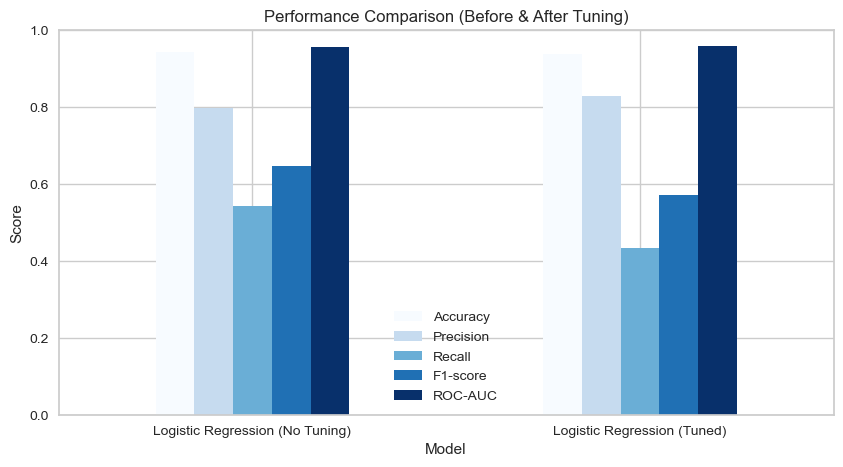

In [45]:
# Combine results
comparison = pd.concat([results, tuned_results], ignore_index=True)

# Display results
print("\nPerformance Comparison:\n", comparison)

# Visualize comparison
comparison.set_index('Model').plot(kind='bar', figsize=(10, 5), colormap='Blues', rot=0)
plt.title('Performance Comparison (Before & After Tuning)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Model by model comparison with and without tuning

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


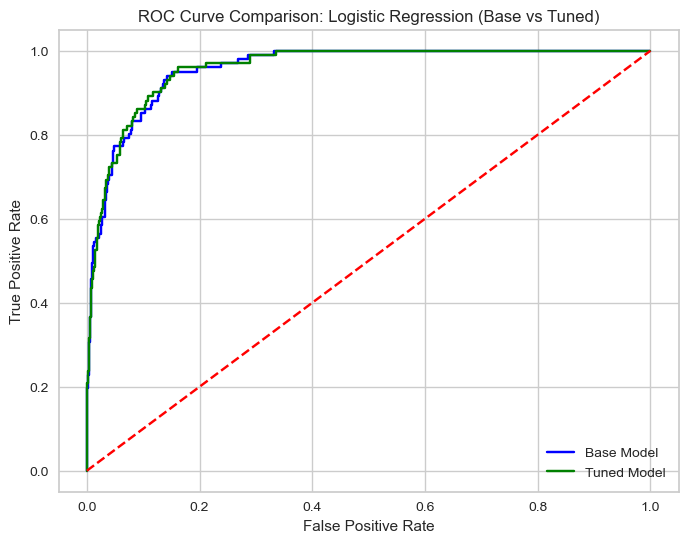

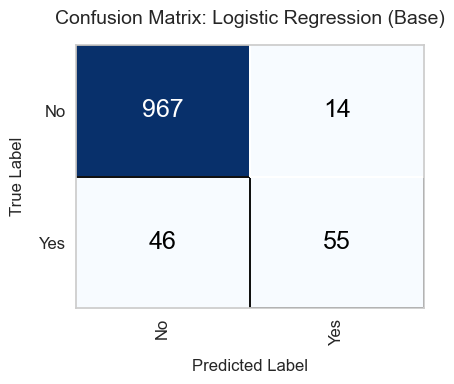

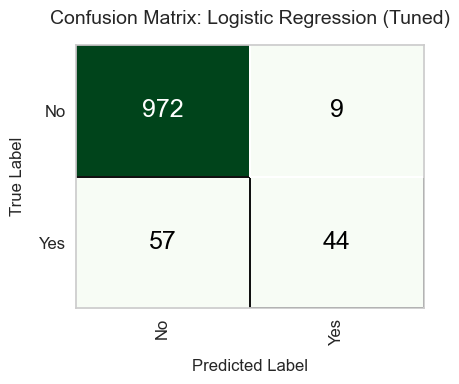

Logistic Regression (Base):
Accuracy: 0.9445
Precision: 0.7971
Recall: 0.5446
F1-score: 0.6471
ROC-AUC: 0.9576
Confusion Matrix:
 [[967  14]
 [ 46  55]]

Logistic Regression (Tuned):
Accuracy: 0.9390
Precision: 0.8302
Recall: 0.4356
F1-score: 0.5714
ROC-AUC: 0.9591
Confusion Matrix:
 [[972   9]
 [ 57  44]]


In [138]:
# Logistic Regression
# Define features and target
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# ------ Logistic Regression WITHOUT Hyperparameter Tuning ------
log_reg_base = LogisticRegression(max_iter=1000, random_state=42)
log_reg_base.fit(X_train, y_train)

# Predictions
y_pred_base = log_reg_base.predict(X_test)
y_prob_base = log_reg_base.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
roc_auc_base = roc_auc_score(y_test, y_prob_base)
conf_matrix_base = confusion_matrix(y_test, y_pred_base)

# ------ Logistic Regression WITH Hyperparameter Tuning ------
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'class_weight': ['balanced', None],
        'penalty': ['l1', 'l2']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs'],
        'class_weight': ['balanced', None],
        'penalty': ['l2']
    }
]

log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_best = best_log_reg.predict(X_test)
y_prob_best = best_log_reg.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# ------ ROC Curve Visualization ------
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, color='blue', label='Base Model')
plt.plot(fpr_best, tpr_best, color='green', label='Tuned Model')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression (Base vs Tuned)')
plt.legend(loc='lower right')
plt.show()

# ------ Confusion Matrix Visualization using Yellowbrick ------
def plot_yellowbrick_cm(model, X_train, y_train, X_test, y_test, title, cmap):
    plt.figure(figsize=(4.5, 4))  # **Reduced matrix size**
    cm = ConfusionMatrix(model, classes=['No', 'Yes'], cmap=cmap, percent=False)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    # Adjust title and labels
    cm.ax.set_title(title, fontsize=14, pad=15)
    cm.ax.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
    cm.ax.set_ylabel('True Label', fontsize=12, labelpad=10)
    
    # Increase font size for matrix numbers
    for text in cm.ax.texts:
        text.set_fontsize(18)  # **Larger numbers inside the matrix**
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_yellowbrick_cm(log_reg_base, X_train, y_train, X_test, y_test, 'Confusion Matrix: Logistic Regression (Base)', 'Blues')
plot_yellowbrick_cm(best_log_reg, X_train, y_train, X_test, y_test, 'Confusion Matrix: Logistic Regression (Tuned)', 'Greens')

# ------ Print Performance Metrics ------
print(f'Logistic Regression (Base):')
print(f'Accuracy: {accuracy_base:.4f}')
print(f'Precision: {precision_base:.4f}')
print(f'Recall: {recall_base:.4f}')
print(f'F1-score: {f1_base:.4f}')
print(f'ROC-AUC: {roc_auc_base:.4f}')
print(f'Confusion Matrix:\n {conf_matrix_base}\n')

print(f'Logistic Regression (Tuned):')
print(f'Accuracy: {accuracy_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'F1-score: {f1_best:.4f}')
print(f'ROC-AUC: {roc_auc_best:.4f}')
print(f'Confusion Matrix:\n {conf_matrix_best}')


Decision Tree (Baseline)
Accuracy: 0.9418
Precision: 0.7794
Recall: 0.5248
F1-score: 0.6272
ROC-AUC: 0.9042
Confusion Matrix:
[[966  15]
 [ 48  53]]

Decision Tree (After Hyperparameter Tuning)
Accuracy: 0.9418
Precision: 0.8393
Recall: 0.4653
F1-score: 0.5987
ROC-AUC: 0.9564
Confusion Matrix:
[[972   9]
 [ 54  47]]


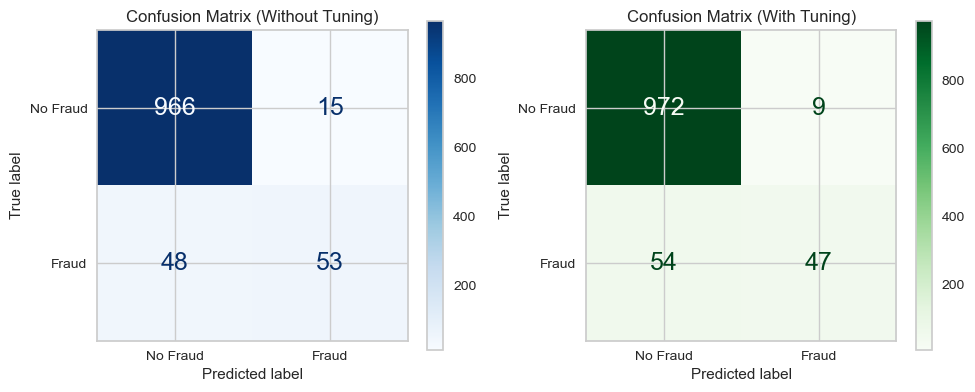

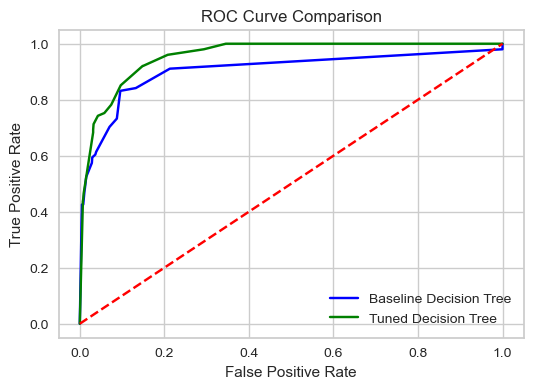

In [47]:
# Decision Tree
#Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### **1. Train Decision Tree without Hyperparameter Tuning**
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

### **2. Train Decision Tree with Hyperparameter Tuning using GridSearchCV**
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_dt_model = grid_search.best_estimator_

# Predictions
y_pred_best = best_dt_model.predict(X_test)
y_prob_best = best_dt_model.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

### **3. Compare Results**
print("\nDecision Tree (Baseline)")
print(f'Accuracy: {accuracy_dt:.4f}')
print(f'Precision: {precision_dt:.4f}')
print(f'Recall: {recall_dt:.4f}')
print(f'F1-score: {f1_dt:.4f}')
print(f'ROC-AUC: {roc_auc_dt:.4f}')
print(f'Confusion Matrix:\n{conf_matrix_dt}')

print("\nDecision Tree (After Hyperparameter Tuning)")
print(f'Accuracy: {accuracy_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'F1-score: {f1_best:.4f}')
print(f'ROC-AUC: {roc_auc_best:.4f}')
print(f'Confusion Matrix:\n{conf_matrix_best}')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Define figure size (smaller than before)
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(ax, conf_matrix, title, cmap):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Fraud', 'Fraud'])
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # 'd' ensures integer display
    ax.set_title(title, fontsize=12)

    # Increase font size of numbers inside matrix
    for text in ax.texts:
        text.set_fontsize(18)

# Plot confusion matrices
plot_conf_matrix(axes[0], conf_matrix_dt, 'Confusion Matrix (Without Tuning)', 'Blues')
plot_conf_matrix(axes[1], conf_matrix_best, 'Confusion Matrix (With Tuning)', 'Greens')

plt.tight_layout()
plt.show()

### **5. ROC Curve Comparison**
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label='Baseline Decision Tree', color='blue')
plt.plot(fpr_best, tpr_best, label='Tuned Decision Tree', color='green')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Random Forest Without Hyperparameter Tuning:
Accuracy: 0.9418
Precision: 0.7500
Recall: 0.5644
F1-score: 0.6441
ROC-AUC: 0.9448
Random Forest With Hyperparameter Tuning:
Accuracy: 0.9427
Precision: 0.7532
Recall: 0.5743
F1-score: 0.6517
ROC-AUC: 0.9571


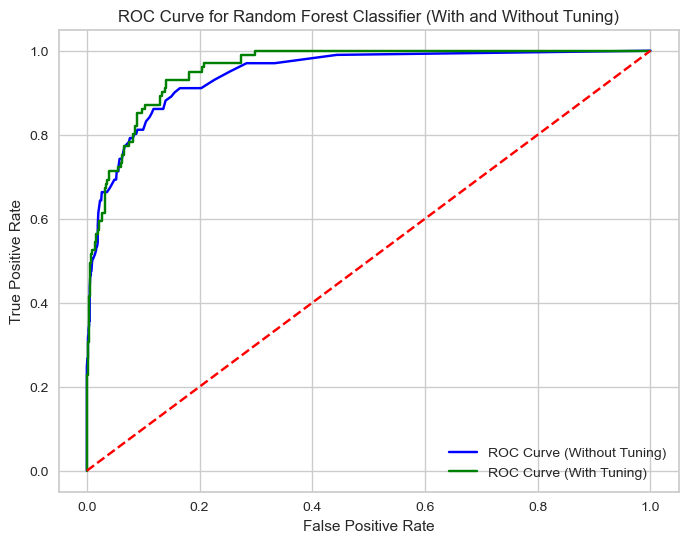

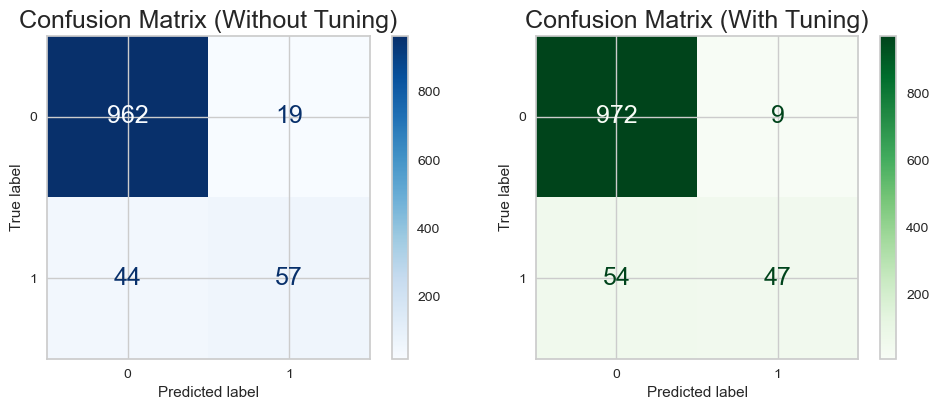

In [48]:
# Random Forest
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------ Random Forest without Hyperparameter Tuning ------

# Create and train Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Random Forest Without Hyperparameter Tuning:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

# Confusion Matrix for Random Forest without Tuning
conf_matrix = confusion_matrix(y_test, y_pred)

# ------ Random Forest with Hyperparameter Tuning ------

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make Predictions and Evaluate the Best Model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, pos_label=1)
recall_best = recall_score(y_test, y_pred_best, pos_label=1)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)

print(f'Random Forest With Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'F1-score: {f1_best:.4f}')
print(f'ROC-AUC: {roc_auc_best:.4f}')

# Visualize the ROC Curve for both models on the same graph
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (Without Tuning)')
plt.plot(fpr_best, tpr_best, color='green', label='ROC Curve (With Tuning)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (With and Without Tuning)')
plt.legend(loc='lower right')# Define a smaller figure size
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(ax, conf_matrix, title, cmap):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # 'd' ensures integer display
    ax.set_title(title, fontsize=18)

    # Increase font size of numbers inside matrix
    for text in ax.texts:
        text.set_fontsize(18)

# Plot confusion matrices
plot_conf_matrix(axes[0], conf_matrix, 'Confusion Matrix (Without Tuning)', 'Blues')
plot_conf_matrix(axes[1], conf_matrix_best, 'Confusion Matrix (With Tuning)', 'Greens')

plt.tight_layout()
plt.show()
plt.show()

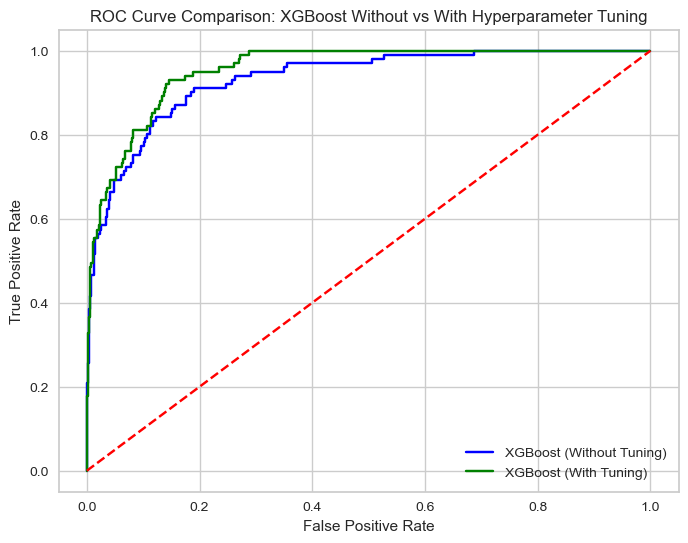

XGBoost Without Hyperparameter Tuning:
Accuracy: 0.9344
Precision: 0.6705
Recall: 0.5842
F1-score: 0.6243
ROC-AUC: 0.9324

XGBoost With Hyperparameter Tuning:
Accuracy: 0.9473
Precision: 0.8333
Recall: 0.5446
F1-score: 0.6587
ROC-AUC: 0.9544


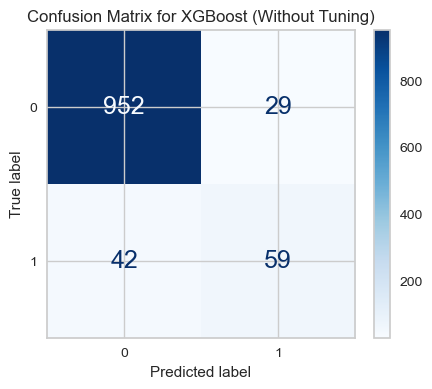

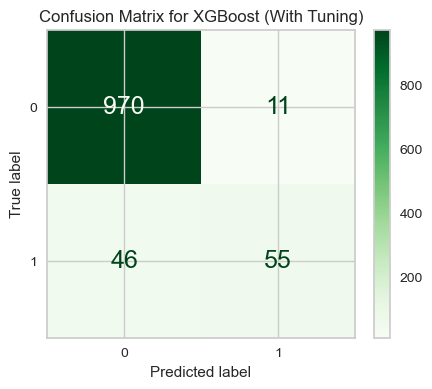

In [120]:
# XG Boost
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------ XGBoost without Hyperparameter Tuning ------
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(random_state=42))])

model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# ------ XGBoost with Hyperparameter Tuning ------
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make Predictions with the Best Model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Compute ROC Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='XGBoost (Without Tuning)')
plt.plot(fpr_best, tpr_best, color='green', label='XGBoost (With Tuning)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: XGBoost Without vs With Hyperparameter Tuning')
plt.legend(loc='lower right')
plt.show()

# Print performance metrics
print(f'XGBoost Without Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}')

print(f'\nXGBoost With Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred_best):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}')

# Compute confusion matrices
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(conf_matrix, title, cmap):
    fig, ax = plt.subplots(figsize=(5, 4))  # Reduced figure size for compact display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # Ensure integer format
    ax.set_title(title, fontsize=12)

    # Increase font size of numbers inside the matrix
    for text in ax.texts:
        text.set_fontsize(18)

    plt.show()

# Plot confusion matrices
plot_conf_matrix(conf_matrix, 'Confusion Matrix for XGBoost (Without Tuning)', 'Blues')
plot_conf_matrix(conf_matrix_best, 'Confusion Matrix for XGBoost (With Tuning)', 'Greens')


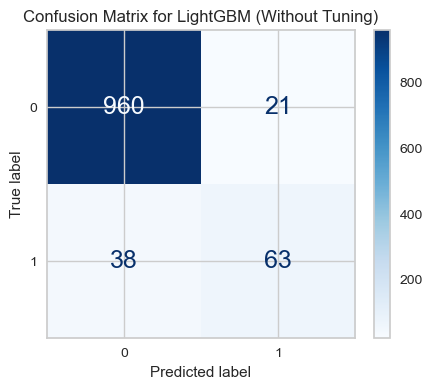

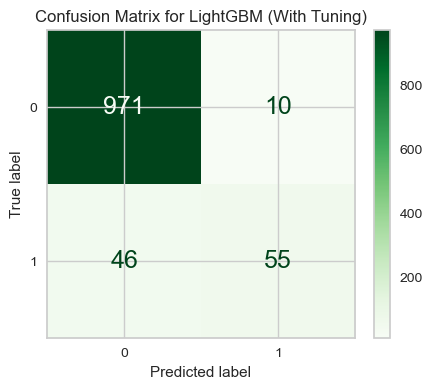

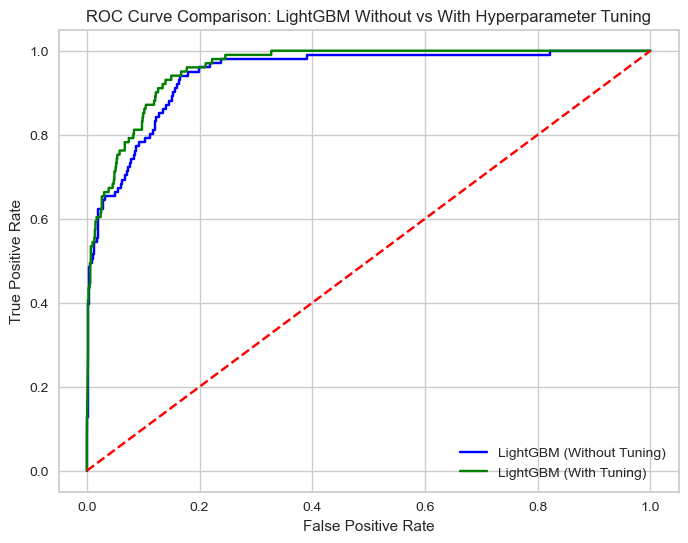

LightGBM Without Hyperparameter Tuning:
Accuracy: 0.9455
Precision: 0.7500
Recall: 0.6238
F1-score: 0.6811
ROC-AUC: 0.9446

LightGBM With Hyperparameter Tuning:
Accuracy: 0.9482
Precision: 0.8462
Recall: 0.5446
F1-score: 0.6627
ROC-AUC: 0.9592


In [124]:
# LightGBM
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Replace NaNs and Inf values
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing pipeline (if needed for categorical data)
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns),
                  ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)]
)

# ------ LightGBM without Hyperparameter Tuning ------
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LGBMClassifier(random_state=42))])

model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ------ LightGBM with Hyperparameter Tuning ------
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make Predictions with the Best Model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Compute confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(conf_matrix, title, cmap):
    fig, ax = plt.subplots(figsize=(5, 4))  # Reduced figure size for compact display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # Ensure integer format
    ax.set_title(title, fontsize=12)

    # Increase font size of numbers inside the matrix
    for text in ax.texts:
        text.set_fontsize(18)

    plt.show()

# Plot confusion matrices
plot_conf_matrix(conf_matrix, 'Confusion Matrix for LightGBM (Without Tuning)', 'Blues')
plot_conf_matrix(conf_matrix_best, 'Confusion Matrix for LightGBM (With Tuning)', 'Greens')

# Compute ROC Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='LightGBM (Without Tuning)')
plt.plot(fpr_best, tpr_best, color='green', label='LightGBM (With Tuning)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: LightGBM Without vs With Hyperparameter Tuning')
plt.legend(loc='lower right')
plt.show()

# Print performance metrics
print(f'LightGBM Without Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}')

print(f'\nLightGBM With Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred_best):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}')

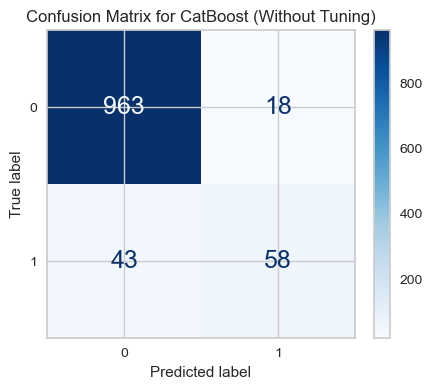

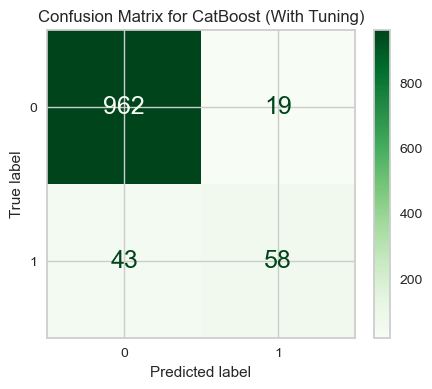

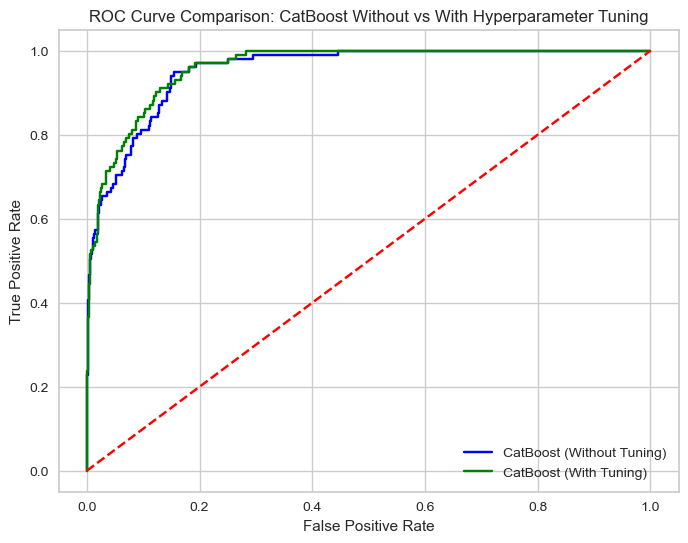

CatBoost Without Hyperparameter Tuning:
Accuracy: 0.9436
Precision: 0.7632
Recall: 0.5743
F1-score: 0.6554
ROC-AUC: 0.9541

CatBoost With Hyperparameter Tuning:
Accuracy: 0.9427
Precision: 0.7532
Recall: 0.5743
F1-score: 0.6517
ROC-AUC: 0.9603


In [126]:
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Replace NaNs and Inf values
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing pipeline (for categorical & numeric features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)
    ]
)

# ------ CatBoost Without Hyperparameter Tuning ------
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(verbose=0, random_state=42))
])

model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ------ CatBoost With Hyperparameter Tuning ------
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [6, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make Predictions with the Best Model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Compute confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(conf_matrix, title, cmap):
    fig, ax = plt.subplots(figsize=(5, 4))  # Reduced figure size for compact display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # Ensure integer format
    ax.set_title(title, fontsize=12)

    # Increase font size of numbers inside the matrix
    for text in ax.texts:
        text.set_fontsize(18)

    plt.show()

# Plot confusion matrices
plot_conf_matrix(conf_matrix, 'Confusion Matrix for CatBoost (Without Tuning)', 'Blues')
plot_conf_matrix(conf_matrix_best, 'Confusion Matrix for CatBoost (With Tuning)', 'Greens')

# Compute ROC Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='CatBoost (Without Tuning)')
plt.plot(fpr_best, tpr_best, color='green', label='CatBoost (With Tuning)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: CatBoost Without vs With Hyperparameter Tuning')
plt.legend(loc='lower right')
plt.show()

# Print performance metrics
print(f'CatBoost Without Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}')

print(f'\nCatBoost With Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred_best):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}')